**Imports**

In [1]:
import tensorflow as tf
import numpy as np
import rcwa_utils
import tensor_utils
import solver
import matplotlib.pyplot as plt

**Loss Function Definition**

In [2]:
def loss_func():
  
  # Global parameters dictionary.
  global params

  # Generate permitivitty and permeability distributions.
  ER_t, UR_t = solver.generate_stacked_cylindrical_nanoposts(var_duty, params)

  # Set the device layer thickness based on the length variable.
  thickness_coeff = tf.clip_by_value(var_length, clip_value_min = params['length_min'], clip_value_max = params['length_max'])
  thickness_coeff = tf.cast(thickness_coeff, dtype = tf.complex64)
  substrate_length_shape = (1, 1, 1, 1, 1, 1)
  device_length_shape = (1, 1, 1, params['Nlay'] - 1, 1, 1)
  substrate_layer = tf.ones(shape = substrate_length_shape, dtype = tf.complex64)
  device_layer = thickness_coeff * tf.ones(shape = device_length_shape, dtype = tf.complex64)
  wavelength = params['lam0'][0, 0, 0, 0, 0, 0].numpy()
  params['L'] = wavelength * tf.concat([device_layer, substrate_layer], axis = 3)

  # Simulate the system.
  outputs = solver.simulate(ER_t, UR_t, params)

  # Maximize the reflectance at the first angle and minimize the reflectance at the second angle.
  ref_theta1 = outputs['REF'][0, 0, 0]
  ref_theta2 = outputs['REF'][1, 0, 0]

  return -ref_theta1 * (1 - ref_theta2)

**Setup and Initialize Variables**

In [3]:
# Initialize duty cycle variable and global params dictionary.
params = solver.initialize_params(wavelengths = [632.0, 632.0],
                      thetas = [2.5, 7.5],
                      phis = [0.0, 0.0],
                      pte = [1.0, 1.0],
                      ptm = [0.0, 0.0])
params['erd'] = 6.76 # Grating layer permittivity.
params['ers'] = 2.25 # Subtrate layer permittivity.
params['PQ'] = [11, 11] # Fourier Harmonics.
params['batchSize'] = 2

# Initialize grating duty cycle variables for top and bottom cylinders.
params['Nlay'] = 3
Nlay = params['Nlay']
var_shape = (1, params['pixelsX'], params['pixelsY'], params['Nlay'] - 1)
duty_initial = np.ones(shape = var_shape)
duty_initial[0, 0, 0, 0] = 0.8
duty_initial[0, 0, 0, 1] = 0.4
var_duty = tf.Variable(duty_initial, dtype = tf.float32)

# Initialize grating thickness variables for top and bottom cylinders.
var_length_shape = (1, 1, 1, params['Nlay'] - 1, 1, 1)
length_initial = np.ones(shape = var_length_shape)
length_initial[0, 0, 0, 0, 0, 0] = 1.0
length_initial[0, 0, 0, 1, 0, 0] = 0.5
var_length = tf.Variable(length_initial, dtype = tf.float32)

**Optimize**

In [4]:
# Number of optimization iterations.
N = 200

# Define an optimizer and data to be stored.
opt = tf.keras.optimizers.Adam(learning_rate = 0.002)
loss = np.zeros(N + 1)

# Compute initial loss.
loss[0] = loss_func().numpy()

# Optimize.
print('Optimizing...')
for i in range(N):
  opt.minimize(loss_func, var_list = [var_duty, var_length])
  loss[i + 1] = loss_func().numpy()

Optimizing...


**Display Learning Curve**

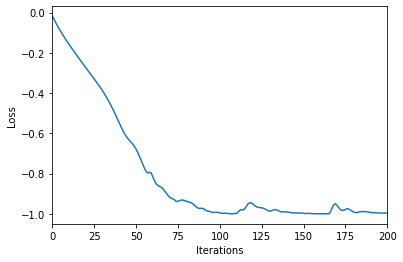

In [5]:
plt.plot(loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.xlim(0, N)
plt.show()